In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('/media/ssd/test/GNN/kaggle/input/BoT-IoT/bot_reduced.csv')

In [3]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','attack','state','proto','seq'],inplace=True)

In [4]:
data.rename(columns={"category": "label"},inplace = True)

In [5]:
data.label.value_counts()

label
DDoS              674318
DoS               577591
Reconnaissance     63757
Normal               477
Theft                 79
Name: count, dtype: int64

In [6]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [7]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [8]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [9]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [10]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [11]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [12]:
data.fillna(0,inplace = True)

In [13]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [14]:
data.drop(columns=['index'],inplace=True)

In [15]:
data

,saddr,daddr,pkts,bytes,ltime,dur,mean,stddev,sum,min,...,state_number_7,state_number_8,state_number_9,state_number_10,state_number_11,proto_number_1,proto_number_2,proto_number_3,proto_number_4,proto_number_5
0,172.18.87.245:25557,192.168.100.7:80,5,770,1.528081e+09,22.413605,1.019545,1.765904,4.078181,0.000000,...,False,False,False,False,False,True,False,False,False,False
1,172.27.222.96:14504,192.168.100.3:80,12,1284,1.528096e+09,45.709064,0.123180,0.124137,0.739081,0.000000,...,False,False,False,False,False,True,False,False,False,False
2,172.22.188.166:25895,192.168.100.6:80,7,890,1.528081e+09,29.529263,0.108645,0.134809,0.543226,0.000000,...,False,False,False,False,False,True,False,False,False,False
3,172.24.2.140:20789,192.168.100.5:80,8,480,1.528085e+09,29.110733,2.114735,1.743680,10.573673,0.000000,...,False,False,False,False,False,False,False,True,False,False
4,172.30.198.176:14478,192.168.100.3:80,5,770,1.528096e+09,13.003353,2.141786,1.516747,6.425359,0.000000,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316217,172.17.213.53:8664,192.168.100.3:80,4,428,1.528096e+09,9.170991,0.007311,0.007311,0.014622,0.000000,...,False,False,False,False,False,True,False,False,False,False
1316218,172.18.248.193:31971,192.168.100.3:80,9,1010,1.528096e+09,12.177457,2.295200,1.325747,9.180801,0.000000,...,False,False,False,False,False,True,False,False,False,False
1316219,172.30.31.193:23649,192.168.100.3:80,8,480,1.528099e+09,14.194368,3.382499,0.951310,10.147496,2.037154,...,False,False,False,False,False,False,False,True,False,False
1316220,172.27.155.188:7165,192.168.100.3:80,4,428,1.528096e+09,10.539588,0.042636,0.042636,0.085273,0.000000,...,False,False,False,False,False,True,False,False,False,False


In [16]:
scaler = StandardScaler()
cols_to_norm = list(set(list(data.iloc[:, 2:].columns ))  - set(list(['label'])) )
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [18]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [19]:
#from dgl.data.utils import load_graphs   
#G = load_graphs("./data.bin")[0][0]

In [20]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [21]:
G = G.to_directed()

In [22]:
G = from_networkx(G,edge_attrs=['h','label'])

In [23]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [24]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1]) 

In [25]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [26]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [27]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [28]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [29]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [30]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [31]:
G.ndata['h'].shape

torch.Size([931841, 1, 55])

In [32]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [33]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [34]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [36]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(G.edata['label'].cpu().numpy()),
    y=G.edata['label'].cpu().numpy()
)

In [37]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [38]:
G = G.to('cuda:0')

In [39]:
G.device

device(type='cuda', index=0)

In [40]:
G.ndata['h'].device  

device(type='cuda', index=0)

In [41]:
G.edata['h'].device  

device(type='cuda', index=0)

In [42]:
 node_features = G.ndata['h']
 edge_features = G.edata['h']

 edge_label = G.edata['label']
 train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

opt = th.optim.Adam(model.parameters())

for epoch in range(1,14500):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.9169201850891113
Epoch: 200  Training acc: 0.9557586908340454
Epoch: 300  Training acc: 0.9791845083236694
Epoch: 400  Training acc: 0.9852527379989624
Epoch: 500  Training acc: 0.988419234752655
Epoch: 600  Training acc: 0.9890129566192627
Epoch: 700  Training acc: 0.9889136552810669
Epoch: 800  Training acc: 0.9909237027168274
Epoch: 900  Training acc: 0.9884322881698608
Epoch: 1000  Training acc: 0.9839296936988831
Epoch: 1100  Training acc: 0.9904602766036987
Epoch: 1200  Training acc: 0.9930217266082764
Epoch: 1300  Training acc: 0.9940425157546997
Epoch: 1400  Training acc: 0.9960677623748779
Epoch: 1500  Training acc: 0.9920210242271423
Epoch: 1600  Training acc: 0.9963461756706238
Epoch: 1700  Training acc: 0.9955858588218689


KeyboardInterrupt: 

In [43]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [44]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 55)

In [45]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [46]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [47]:
G_test = G_test.to('cuda:0')

In [48]:
th.cuda.empty_cache()

In [49]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [50]:
print(str(elapsed) + ' seconds')

0.18916203640401363 seconds


In [51]:
test_pred = test_pred.argmax(1)

In [52]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [53]:
edge_label = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

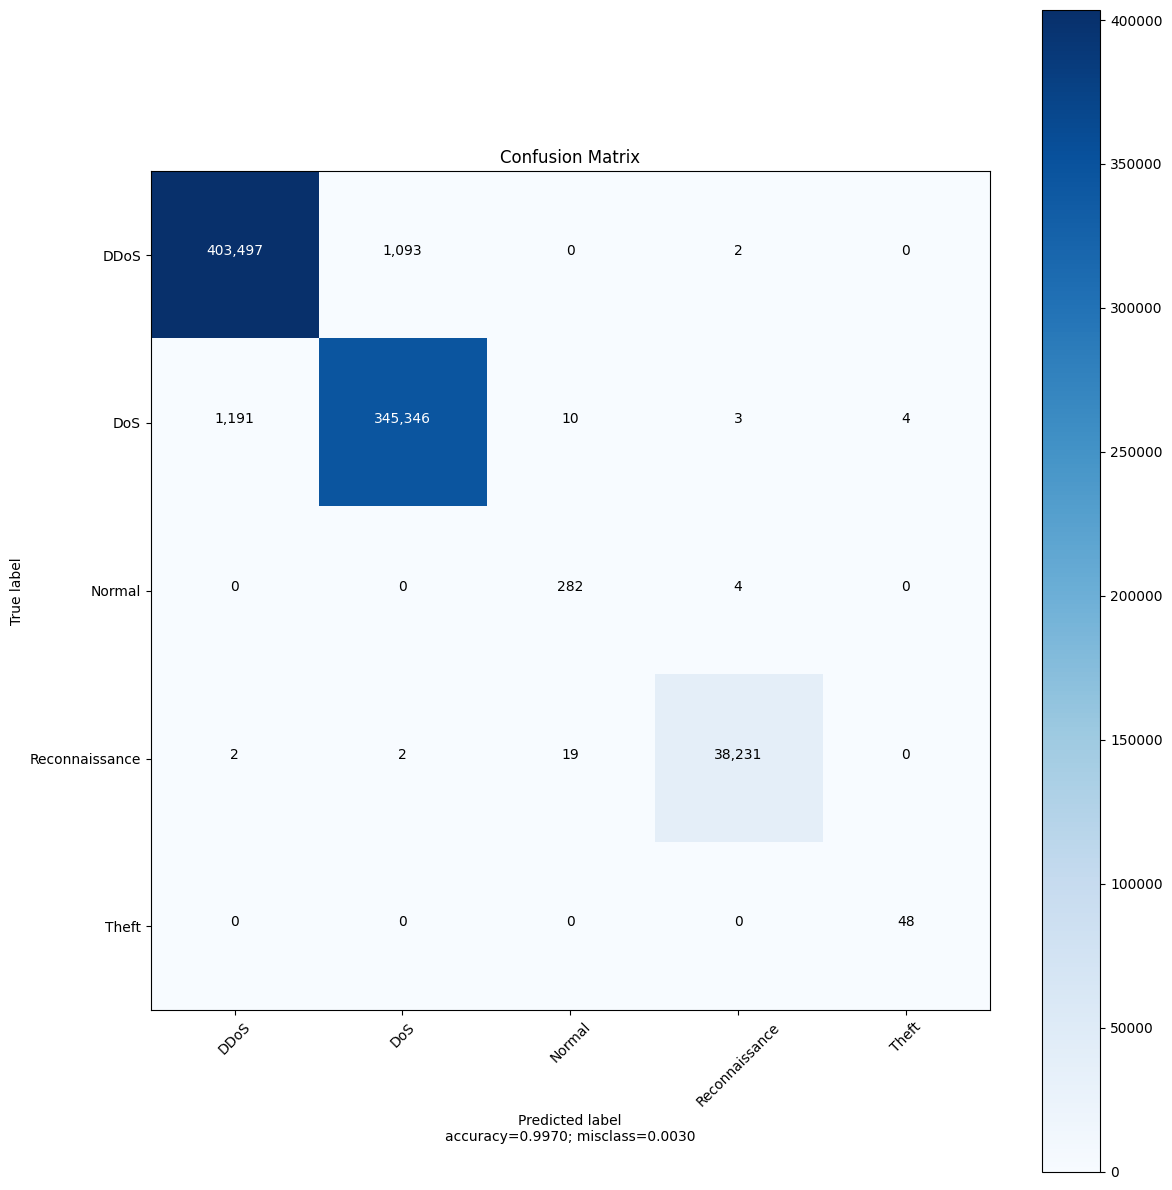

In [55]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred), 
                      normalize    = False,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")